# A gratuitously complex adding machine

Building a FFN that can add two integers between -10 and +10.

<strong>input -> two integer  -> output -> their sum</strong>

building 10 models and reporting performance.
visualizing the true and predicted sums.

First step: Gathering data
best solution i think is to generate data

In [148]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats("svg")

In [149]:
## Generating data
def generateData(m):
    
    # number of samples
    
    
    # features 
    num1 = np.random.randint(-10,11,size=(m,1))
    num2 = np.random.randint(-10,11,size=(m,1))
    
    # labels
    labels = num1 + num2
    
    # plotting the feature points
    # plt.plot(num1,'bs')
    # plt.plot(num2,'r^')
    # plt.show()
    
    dataSet = np.concatenate((num1, num2), axis=1)
    
    # checking the shape of data
    # print(dataSet.shape)
    # print(labels.shape)
    
    ## Creating data loaders

    # creating train , dev  sets
    X_train,X_dev,y_train,y_dev = train_test_split(dataSet, labels, test_size=0.2)
    # creating test sets
    X_dev,X_test,y_dev,y_test = train_test_split(X_dev,y_dev,test_size=0.5)
    
    # creting TensorDataset
    train_dataset = TensorDataset(torch.tensor(X_train).float(),torch.tensor(y_train).float())
    dev_dataset = TensorDataset(torch.tensor(X_dev).float(),torch.tensor(y_dev).float())
    
    # converting to data loader
    batchSize = 32
    train_loader = DataLoader(dataset=train_dataset, batch_size=batchSize, shuffle=True,drop_last=True)
    dev_loader = DataLoader(dataset=dev_dataset, batch_size=dev_dataset.tensors[0].shape[0], shuffle=False)
    
    X_test = torch.tensor(X_test).float()
    y_test = torch.tensor(y_test).float()
    
    return train_loader, dev_loader,(X_test,y_test)


In [150]:
## testing generateData
train_loader,dev_loader,test_dataset =generateData(10000)

### Creating model class
 optimizer : Adam
 #### for loss function we can use cross entropy if we count the sum possibilities as classes, but i would rather choose MSE.(for now)

In [151]:
class Net(nn.Module):
    def __init__(self,nLayers,nUnits):
        super().__init__()
        
        self.layers = nn.ModuleDict()
        self.nLayers = nLayers
        # input layer
        self.layers["input"] = nn.Linear(2, nUnits)
        
        ### hidden layers
        for i in range(nLayers):
            self.layers["layer{}".format(i)] = nn.Linear(nUnits,nUnits)
        
        ### output layer
        self.layers["output"] = nn.Linear(nUnits,1)
        
    def forward(self,x):
        x = F.relu(self.layers["input"](x))
        
        for i in range(self.nLayers):
            x = F.relu(self.layers[f"layer{i}"](x))
            
        return self.layers["output"](x)
        

In [152]:
def createNet(nLayers,nUnits):
    
    net = Net(nLayers,nUnits)
    
    lossFn = nn.MSELoss()
    
    optimizer = torch.optim.Adam(net.parameters(),lr=0.001)
    
    return net,lossFn,optimizer

In [153]:
def trainModel(nLayers,nUnits):
    
    # number of epochs
    num_epochs = 50
    
    #  create new model
    net, lossFn,optimizer = createNet(nLayers,nUnits)
    
    # init losses
    losses = torch.zeros(num_epochs)
    trainAcc = []
    devsetAcc = []
    
    # looping over epochs
    for epochI in range(num_epochs):
        net.train()
        # loop over batches
        batchAcc = []
        batchLoss = []
        for X,y in train_loader:
            
            # forward pass and loss
            yhat = net(X)
            loss = lossFn(yhat,y)
            
            # backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            batchLoss.append(loss.item())
            
            # compute acc
            absoluteErr = torch.abs(torch.round(yhat) - torch.round(y))
            accPct = 100*torch.mean((absoluteErr == 0).float())
            batchAcc.append(accPct)
            # end of batch loop...
        
        trainAcc.append(np.mean(batchAcc))
        
        
        losses[epochI] = np.mean(batchLoss)
        
        net.eval()
        X,y = next(iter(dev_loader))
        with torch.no_grad():
            yHat = net(X)
        
        devsetAcc.append( 100*(torch.abs(torch.round(yHat) - torch.round(y)) == 0).float().mean())
        
    return trainAcc,devsetAcc,losses,net

In [154]:
### testing class
net2 = Net(2,8)
X,y = next(iter(train_loader))
yHat = net2(X)

In [155]:
### testing train model
trainAcc,devsetAcc,losses,net = trainModel(2,8)

print(np.mean(trainAcc[-5:]))

100.0


### Running Experiment

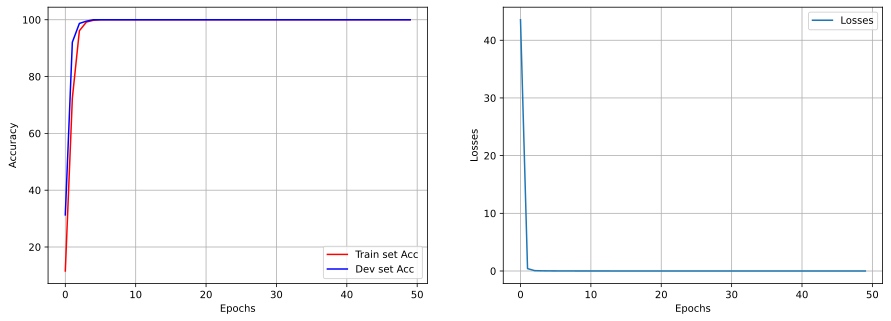

In [156]:
### randomly found 2 layers and 8 units lets plot it
fig,ax = plt.subplots(1,2,figsize=(15,5))

ax[0].plot(trainAcc,'r-',label="Train set Acc")
ax[0].plot(devsetAcc,'b-',label="Dev set Acc")
ax[0].set_ylabel("Accuracy")

ax[1].plot(losses,label="Losses")
ax[1].set_ylabel("Losses")

for axs in ax.flatten():
    axs.legend()
    axs.grid(True)
    axs.set_xlabel("Epochs")



plt.show()


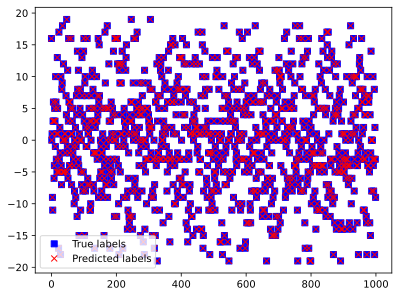

In [157]:
### Testing on test set
X,y = test_dataset
yHat = net(X)

plt.plot(y,'bs',label="True labels")
plt.plot(np.round(yHat.detach()),'rx',label="Predicted labels")
plt.legend()
plt.show()

In [158]:
### experiment parameter
# layers_spect = np.arange(1,5)
# units_spect = 2**np.arange(1,7)
# 
# for layerI in range(len(layers_spect)):
#     
#     for unitI in range(len(units_spect)):
#         
#         trainModel()